# imports

In [8]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
path = os.getcwd()

if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/read_matlab_file.ipynb
    %run /Home/siv30/wad005/master/GRB/src/convert_erg.ipynb
else:
    %run /Users/andreas/phys/master/GRB/src/read_matlab_file.ipynb
    %run /Users/andreas/phys/master/GRB/src/convert_erg.ipynb


All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!


# Notes
    Pandas syntax:

    -iloc retrives the chronological index 
    -loc retrives the label index 

# Satety time DF

In [2]:
st_df = pd.read_csv(path_ST)
st_df = st_df.rename(columns={"pmt":"det"})
st_df.head()

,adr,dau,det,E0_kev,minimum_dt_us
0,1,1,1,400,0
1,1,1,1,500,1
2,1,1,1,1000,3
3,1,1,1,2500,11
4,1,1,1,3000,13


# cutting df

In [3]:
adr_1_df = st_df.truncate(after=22)
adr_2_df = st_df.truncate(before=23,after=45)
adr_3_df = st_df.truncate(before=46,after=68)
adr_4_df = st_df.truncate(before=69,after=91)
adr_5_df = st_df.truncate(before=92,after=114)
adr_6_df = st_df.truncate(before=115,after=137)
adr_7_df = st_df.truncate(before=138,after=160)
adr_8_df = st_df.truncate(before=161,after=183)
adr_9_df = st_df.truncate(before=184,after=206)
adr_10_df = st_df.truncate(before=207,after=229)
adr_11_df = st_df.truncate(before=230,after=252)
adr_12_df = st_df.truncate(before=253)

adr_df_list = [adr_1_df,adr_2_df, adr_3_df,adr_4_df,  adr_5_df,adr_6_df,  adr_7_df,adr_8_df,  adr_9_df,adr_10_df,  adr_11_df,adr_12_df] #validated ok!

# Getter functions for estimating safety time

In [4]:
def est_st(adr=None,keV=None):
    """Estimating safetytime for a given adr to detector
    and a given keV from energy channel"""
    if keV<=400:
        return 0
    else:
        dt_arr = adr_df_list[adr-1]["minimum_dt_us"].values
        keV_arr = adr_df_list[adr-1]["E0_kev"].values
        f = interp1d(keV_arr,dt_arr,fill_value="extrapolate",bounds_error=False) #fill_value="extrapolate"  --> specifying what happens if one specifies an input value that is out of bounds used for general function
        sf = f(keV)
        return np.float32(sf)

In [5]:
def get_st(df):
    '''
    st retured in microseconds
    
    '''
    adr_arr = df["adr"].to_numpy()
    keV_arr = df["keV"].to_numpy()
    
    return np.array([est_st(adr, keV) for adr, keV in zip(adr_arr, keV_arr)])

In [6]:
def get_dt(df):
    '''
    df['tus'] must be given in microseconds
    '''
    adr_arr = df["adr"].to_numpy()
    tus_arr = df["tus"].to_numpy()
    dt_temp = [0] + [np.abs(tus_arr[i] - tus_arr[i-1]) if adr_arr[i] == adr_arr[i-1] else 0 for i in range(1, len(tus_arr))]
    return dt_temp

def get_dt(df):
    '''
    df['tus'] must be given in microseconds
    '''
    dt_temp = []
    adr_arr = df["adr"].to_numpy()
    tus_arr = df["tus"].to_numpy()
    
    for i,tus in enumerate(tus_arr):
        if i == 0:
            dt_temp.append(0) #at the start of the array. No dt to next because its the last one
        elif adr_arr[i] != adr_arr[i-1]:
            dt_temp.append(0) #No prev trigger at border
        else:
            dt_temp.append(np.abs(tus-tus_arr[i-1])) #appending the dt 
    return dt_temp

In [2]:
def get_flag(df):
    '''
    df['tus'] must be given in microseconds
    returns: np.array(flag)
    '''
    df = df.sort_values(by=['adr','tus'])
    st,dt = df['st'].to_numpy(dtype=np.float64),df['dt'].to_numpy(dtype=np.float64)
    flag = [None]*len(st)
    for i,(s,d) in enumerate(zip(st,dt[1:])): #need to make the i skip n interations due to the while loop
        if s>d:
            flag[i] = True
            scount = s-d
            while scount>0:
                i += 1
                if i+1 < len(dt):
                    scount -= dt[i+1] # 2 comes from: +1 is from the zip and +1 from the next
                    if scount>0:
                        flag[i] = True
                    else:
                        flag[i] = False
                else:
                    flag[i] = True
                    break
        else:
            if flag[i] == None:
                flag[i] = False

    flag.insert(0,False)
    flag.pop(-1)
    return(np.array(flag))

# Interpolation of safety time as a function energy of for all the detectors

In [ ]:
#Creating 6x2 subplots for all the safety time estimates for all the detectors
fig, (axs1,axs2,axs3,axs4,axs5,axs6) = plt.subplots(6,2,figsize=(12,15))
axs_list = [axs1,axs2,axs3,axs4,axs5,axs6]
for i,axs in enumerate(axs_list):
    first_idx = i*2
    sec_idx = i*2 +1
    
    dt_0 = adr_df_list[first_idx]["minimum_dt_us"].values
    keV_0 = adr_df_list[first_idx]["E0_kev"].values
    f_0 = interp1d(dt_0, keV_0) #fill_value="extrapolate"  --> specifying what happens if one specifies an input value that is out of bounds used for general function
    dt_0_new = np.arange(min(dt_0),max(dt_0),0.01)
    keV_0_new = f_0(dt_0_new)

    axs[0].plot(dt_0, keV_0,'r+',label="Data point")
    axs[0].plot(dt_0_new, keV_0_new, '--',label="Interpolation")
    axs[0].set_yscale('log')
    axs[0].set_title("Adr {}".format(str(first_idx + 1)), fontweight='bold')
    axs[0].set_xlabel('Safety time [us]')
    axs[0].set_ylabel('Energy [keV]')
    axs[0].legend()
    
    dt_1 = adr_df_list[sec_idx]["minimum_dt_us"].values
    keV_1 = adr_df_list[sec_idx]["E0_kev"].values
    f_1 = interp1d(dt_1, keV_1) #fill_value="extrapolate"  --> specifying what happens if one specifies an input value that is out of bounds used for general function
    dt_1_new = np.arange(min(dt_1),max(dt_1),0.01)
    keV_1_new = f_1(dt_1_new)
    
    axs[1].plot(dt_1, keV_1, 'r+',label="Data point")
    axs[1].plot(dt_1_new, keV_1_new, '--',label="Interpolation")
    axs[1].set_yscale('log')
    axs[1].set_title("Adr {}".format(str(sec_idx + 1)), fontweight='bold')
    axs[1].set_xlabel('Safety time [us]')
    axs[1].set_ylabel('Energy [keV]')
    axs[1].legend()
    
fig.tight_layout(pad=2.5)
fig.suptitle("Energy vs Safety Time", fontweight='bold',fontsize=20)

#plt.savefig("/Users/andreas/phys/master/GRB/pyplots/safetytime/ST_detectors.png",format="png",dpi=300)
plt.show()

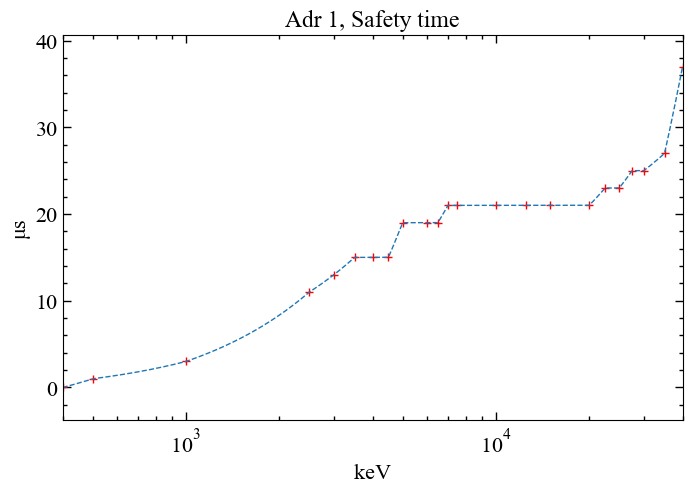

In [12]:
dt_arr = adr_df_list[0]["minimum_dt_us"].values
keV_arr = adr_df_list[0]["E0_kev"].values
f = interp1d(keV_arr,dt_arr,fill_value="extrapolate",bounds_error=False) #fill_value="extrapolate"  --> specifying what happens if one specifies an input value that is out of bounds used for general function
keV_new = np.arange(min(keV_arr),max(keV_arr),0.01)
dt_new = f(keV_new)
plt.plot(keV_arr,dt_arr, 'r+', keV_new, dt_new,'--') #, keV_new,dt_new,'-'
plt.xscale('log')
plt.xlabel('$keV$')
plt.ylabel(u"\u03BCs")
plt.title("Adr 1, Safety time")
#plt.savefig("/Users/andreas/phys/master/GRB/pyplots/safetytime/ST_energy.png",format="png")
plt.show()

In [16]:
print("safety_time.ipynb loaded successfully!")

safety_time.ipynb loaded successfully!
